In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [59]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [60]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [61]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [62]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [63]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier

primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [64]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

ugrhi10 = trainingd

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [65]:
ugrhi10

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [66]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '06 - ALTO TIÊTE']

In [67]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [68]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [69]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())

valor NaN: 2


In [70]:
trainingd = trainingd.dropna(axis=0,how='any')


In [71]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())
trainingd

valor NaN: 0


,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [72]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < inferior.valor)]

outlier

primeiro_quartil: valor    6.583333
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.002667
Name: 0.75, dtype: float64
fig: valor    0.419333
dtype: float64
Inferior: valor    5.954333
dtype: float64
Superior: valor    7.631667
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1979-11-30,5.916667
1985-03-31,5.883333


In [73]:
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [74]:
#Remove a última linha do dataframe
trainingd = trainingd.drop(trainingd[trainingd.index == '2019-09-30'].index)

In [75]:
trainingd.describe()

,valor
count,248.000000
mean,6.793328
std,0.294764
min,5.883333
25%,6.581944
50%,6.838095
75%,7.001821
max,7.405000


In [76]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingds.valor < inferior.valor] = 6.79

ugrhi06 = trainingd

outlier = trainingd[(trainingd.valor < inferior.valor)]

outlier

,valor
data_coleta,


In [77]:
X = ugrhi10
y = ugrhi06

assert X.shape == (len(X),1)
assert y.shape == (len(y),1)

In [78]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

In [79]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#y_test

In [80]:

model = Sequential()
model.add(LSTM(units = 10, input_shape = (X_train.shape[1], 1)))
model.add(Dense(10, activation = 'linear'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

#Treina o modelo
model.fit(X_train,y_train, batch_size = 32, epochs = 100)


Train on 173 samples
Epoch 1/100
173/173 [==============================] - 2s 11ms/sample - loss: 0.5261 - mean_absolute_error: 0.5261
Epoch 2/100
173/173 [==============================] - 0s 787us/sample - loss: 0.4749 - mean_absolute_error: 0.4749
Epoch 3/100
173/173 [==============================] - 0s 144us/sample - loss: 0.4200 - mean_absolute_error: 0.4200
Epoch 4/100
173/173 [==============================] - 0s 167us/sample - loss: 0.3737 - mean_absolute_error: 0.3737
Epoch 5/100
173/173 [==============================] - 0s 218us/sample - loss: 0.3301 - mean_absolute_error: 0.3301
Epoch 6/100
173/173 [==============================] - 0s 249us/sample - loss: 0.2830 - mean_absolute_error: 0.2830
Epoch 7/100
173/173 [==============================] - 0s 210us/sample - loss: 0.2420 - mean_absolute_error: 0.2420
Epoch 8/100
173/173 [==============================] - 0s 110us/sample - loss: 0.2081 - mean_absolute_error: 0.2081
Epoch 9/100
173/173 [==============================]

Epoch 71/100
173/173 [==============================] - 0s 237us/sample - loss: 0.1543 - mean_absolute_error: 0.1543
Epoch 72/100
173/173 [==============================] - 0s 238us/sample - loss: 0.1690 - mean_absolute_error: 0.1690
Epoch 73/100
173/173 [==============================] - 0s 188us/sample - loss: 0.1587 - mean_absolute_error: 0.1587
Epoch 74/100
173/173 [==============================] - 0s 225us/sample - loss: 0.1607 - mean_absolute_error: 0.1607
Epoch 75/100
173/173 [==============================] - 0s 167us/sample - loss: 0.1644 - mean_absolute_error: 0.1644
Epoch 76/100
173/173 [==============================] - 0s 127us/sample - loss: 0.1590 - mean_absolute_error: 0.1590
Epoch 77/100
173/173 [==============================] - 0s 192us/sample - loss: 0.1536 - mean_absolute_error: 0.1536
Epoch 78/100
173/173 [==============================] - 0s 210us/sample - loss: 0.1536 - mean_absolute_error: 0.1536
Epoch 79/100
173/173 [==============================] - 0s 201us

In [81]:
y_pred = model.predict(X_test)
#y_pred = y_pred.reshape(-1, 1)
y_pred = sc.inverse_transform(y_pred)

X_test = X_test.reshape((len(X_test),1))
X_test = sc.inverse_transform(X_test)
y_test = sc.inverse_transform(y_test)
X_test.shape

(75, 1)

In [82]:
y_predt = model.predict(X_train)
#y_pred = y_pred.reshape(-1, 1)
y_predt = sc.inverse_transform(y_predt)

X_train = X_train.reshape((len(X_train),1))
X_train = sc.inverse_transform(X_train)

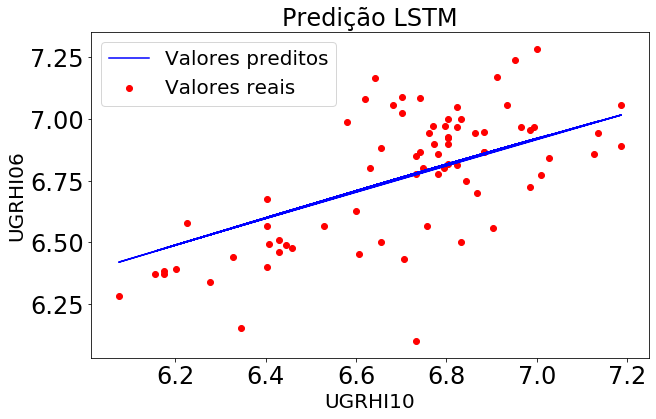

In [83]:
plt.scatter(X_test,y_test,color='red',marker = 'o',label='Valores reais')
plt.plot(X_test,y_pred,color='blue', label='Valores preditos')
#plt.plot(y_pred,color='blue',label='Dados previsto')
#plt.plot(y_test,color='blue',label='Dados teste')
plt.xlabel('UGRHI10')
plt.ylabel('UGRHI06')
plt.legend()
plt.title('Predição LSTM')
plt.show()

In [84]:
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

In [85]:
print('\n')
print('MAPE TESTE:',round(mape(y_pred,y_test)[0],2),'%')
print('RMSE TESTE:',round(rmse(y_pred,y_test),2))
print('R TESTE:',round(r2(y_pred,y_test),2))
print('\n')

print('\n')
print('MAPE TREINO:',round(mape(y_predt,X_train)[0],2),'%')
print('RMSE TREINO:',round(rmse(y_predt,X_train),2))
print('R TREINO:',round(r2(y_predt,X_train),2))
print('\n')



MAPE TESTE: 1.75 %
RMSE TESTE: 0.2
R TESTE: 0.44




MAPE TREINO: 2.67 %
RMSE TREINO: 0.13
R TREINO: 0.78


